In [1]:
import numpy as np
import tensorflow as tf
import metrics as metrics
import Diffusion as df
import os.path
from autoencoder import *
import plotting as plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import keras
from keras.utils import np_utils, to_categorical
from keras.layers import Dense, Input, Flatten, Lambda
from keras.models import Model, Sequential
from keras import regularizers
from keras.datasets import mnist
from keras_adabound import AdaBound
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from sklearn.neighbors import NearestNeighbors
from IPython.core.debugger import set_trace
import random
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from scipy.spatial.distance import pdist
import time
from utils import *

Using TensorFlow backend.


In [2]:
np.random.seed(123)

# Load the dataset
Using the MNIST dataset to train an autoencoder that uses the diffusion map in the embedded space. 

An image is 28x28 pixels, i.e. 784 dimensions.

There are 60 000 training examples and 10 000 test examples. Here we downsample to 1 000 in training.  

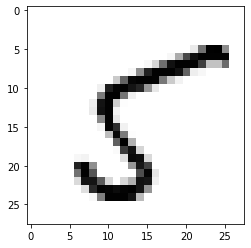

In [3]:
(x_train_full, y_train_full),(x_test_full, y_test_full) = mnist.load_data()


def subsample_data(x_train, y_train, x_test, y_test, num_train, num_test=0):
    train_idx = np.random.choice(x_train.shape[0], num_train, replace=False)
    test_idx = np.random.choice(x_test.shape[0], num_test, replace=False)
    x_train = x_train[train_idx,:,:]
    y_train = y_train[train_idx]
    x_test = x_test[test_idx,:,:]
    y_test = y_test[test_idx]
    return (x_train, y_train),(x_test, y_test)


def preprocess_data(x_train, x_test):
    x_train = x_train.astype("float")/255.0
    x_test = x_test.astype("float")/255.0
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    return (x_train, x_test)


num_train = 1000
num_test = 100
(x_train, y_train),(x_test, y_test) = subsample_data(x_train_full, y_train_full, x_test_full, y_test_full,
                                                     num_train=num_train, num_test=num_test)
plt.imshow(x_train[int(np.random.choice(100, 1))], cmap="Greys")
x_train, x_test = preprocess_data(x_train, x_test)

## Metric
The dimensionality reduction can have two different purposes: classification and manifold learning. For manifold learning we seek parameters that best capture the manifold's intrinsic structure. For classification, we want to select parameters that is optimal with respect the the classification results. 

There are several parameters to select in the diffusion map, all affecting the success of the embedding space. In a classification setting, the selected parameters depend on the training data and the model at hand. Thus, in principle there may to be possible to define "optimal" parameters independently of the data. It is possible to apply the classifier directly to obtain a loss used on cross validatation, but then one have to reapply the model for each parameter. It is therefore beneficial to have a metric that reflects the quality of the embedding without having to apply a classifier model.

In [5](https://arxiv.org/pdf/1707.01093.pdf) they adress the selection of the scale parameter in the Gaussian kernel for both manifold learning and classification. 

We start with the metrics for classification. Dimensionality reduction can drastically improve classification results [ref], and the parameters playes a crucial role in the performance of the kernel methods for dimensionality reduction. They propose three methods for estimating the scale parameter

* The geometric approach
* The probabilistic approach
* The spectral approach. 



In [4]:
sigmas = np.linspace(1, 100, 20)
met = {"geometric": [], "spectral": [], "probabilistic": []}
for sigma in sigmas:
    embed, _, eig = df.diffusion_map(x_train, k=9, dim=3, sigma=sigma)
    met = metrics.get_metrics(y_train, met = met, embedding=embed, x_train=x_train, 
                              eig=eig, sigma=sigma, k=9, ref_neighbor=3)

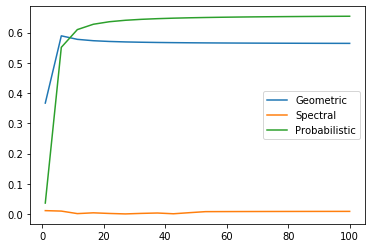

In [5]:
fig, ax = plt.subplots()
ax.plot(sigmas, met["geometric"], label="Geometric")
ax.plot(sigmas, met["spectral"], label="Spectral")
ax.plot(sigmas, met["probabilistic"], label="Probabilistic")
ax.legend()
plt.show()

### Scale parameter / KNN parameter
Both the scale parameter and the number of neighbors in KNN affects the locality in the kernel.  

We'll first try out the default setting for the scale parameter, the median. 

In [ ]:
embed_train_median, _, eig_median = df.diffusion_map(x_train, k=9, dim=3, sigma=0)
plotting.plot_3d_interactive(embed_train_median, y_train)
print(metrics.get_metrics(y_train, embedding=embed_train_median, x_train=x_train, eig=eig_median, sigma=0, k=9))

Now we try with the self tuning scale parameter.

In [9]:
embed_train_adap, _, eig_adap = df.diffusion_map(x_train, k=9, dim=3, sigma="adaptive", ref_neighbor=3)
print(metrics.get_metrics(y_train, embedding=embed_train_adap, x_train=x_train, eig=eig_adap, sigma="adaptive", k=9,
                         ref_neighbor=3))

{'geometric': 0.5732126086633137, 'spectral': 0.016384125951115047, 'probabilistic': 0.5575875722682474}


The plots using self tuning scale parameter and the median look really similar, but rotated. The values where manually inspected to check if the results where in fact equivalent, but they where not. One could also see this be plotting the difference. Use the function `plot_3d_interactive` to plot in 3d and inspect. 

Since the self tuning scale parameter uses the local neighborhood, it might be better to increase the number of neighbors in the KNN affinity matrix. We also test using all of the points in the KNN search, and compare using the all points in the median scale parameter. 

In [11]:
embed_train_adap_100, _, eig_adap_100 = df.diffusion_map(x_train, k=100, dim=3, sigma="adaptive", ref_neighbor=3)
print(metrics.get_metrics(y_train, embedding=embed_train_adap_100, x_train=x_train, eig=eig_adap_100, sigma="adaptive", k=9,
                         ref_neighbor=3))

{'geometric': 0.27405417497488865, 'spectral': 0.016384125951115047, 'probabilistic': 0.40807547174804093}


Now test with using all the points in the affinity matrix.

In [12]:
embed_train_adap_all, _ , eig_adap_all = df.diffusion_map(x_train, k=x_train.shape[0], dim=3, sigma="adaptive", 
                                                          ref_neighbor = 3)
print(metrics.get_metrics(y_train, embedding=embed_train_adap_all, x_train=x_train, eig=eig_adap_all, sigma="adaptive",
                          k=9,ref_neighbor=3))

{'geometric': 0.24004268339664347, 'spectral': 0.016384125951115047, 'probabilistic': 0.121114324212938}


In [16]:
embed_train_median_all, _, eig_median_all = df.diffusion_map(x_train, k=x_train.shape[0], dim=3, sigma=0)
print(metrics.get_metrics(y_train, embedding=embed_train_median_all, x_train=x_train, eig=eig_median_all, 
                          sigma=0, k=9))

{'geometric': 0.2187965726172235, 'spectral': 0.00029657233513803467, 'probabilistic': 0.11263160999053941}


It is clear that using more points in the KNN search is not benefintial for when the scale is median is constant. This is because we loose information about the local environment.

We'll now try to find a global parameter according to the method proposed by Singer et al. 

In [18]:
sigmas_log =  np.linspace(-1, 5, 20) 
sigmas = np.exp(sigmas_log)
Ls = []
for sigma in sigmas:
    _, affinity, _ = df.diffusion_map(x_train, k=x_train.shape[0], dim=3, sigma=sigma, ref_neighbor=7)
    Ls.append(affinity.sum())

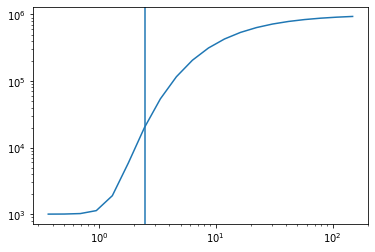

In [20]:
plt.loglog(sigmas, Ls)
plt.axvline(x=2.5)
plt.show()

In [23]:
embed_train_global, _, eig_global = df.diffusion_map(x_train, k=9, dim=3, sigma=2.5)
print(metrics.get_metrics(y_train, embedding=embed_train_median_all, x_train=x_train, eig=eig_median_all, 
                          sigma=2.5, k=9))

{'geometric': 0.2187965726172235, 'spectral': 0.00029657233513803467, 'probabilistic': 0.11263160999053941}


## Inspecting eigenvalues

Let's inspect the eigenvalues by first looking at the magnitude of the sorted values. The largest eigenvalue is 1 since $P$ is a transition matrix. A significant gap between eigenvalues would indicate how many eigenvalues to select in the diffusion map. We do this analysis for different values of sizes of the dataset $N$. 

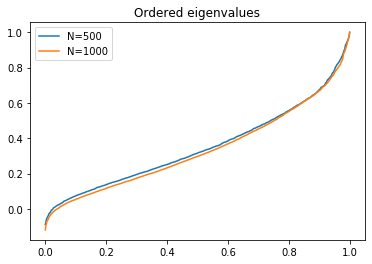

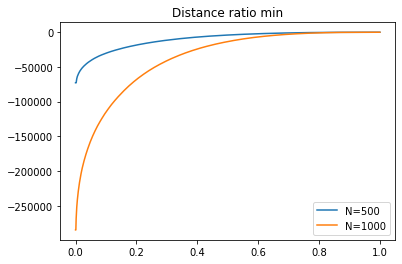

In [26]:
dataset_sizes = [500, 1000]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for size in dataset_sizes:
    (x_train_new, _),(x_test_new, _) = subsample_data(x_train_full, y_train_full, x_test_full, y_test_full, size)
    x_train_inspect, x_test_inspect = preprocess_data(x_train_new, x_test_new)
    _, _, eig = df.diffusion_map(x_train_inspect, k=9, dim=1, sigma=5)
    
    plotting.plot_eigenvalues(eig, ax=ax1, label=f"N={size}", show=False)
    
    plotting.plot_distance_ratio_sum(eig, ax=ax2, label=f"N={size}", show=False)
    
    # plotting.plot_distance_ratio_min(eig, ax=ax2, label=f"N={size}", show=False)


ax1.set_title("Ordered eigenvalues")
ax1.legend()

ax2.set_title("Distance ratio")
ax2.legend()
plt.show()

### Step parameter
Now let's experiment with the time parameter $t$ that decides number of steps in the Markov chain defined by the transition matrix $P$. More specifically, the diffusion metric between $x_i$ and $x_j$ sums the probabilities of all possible paths of length $t$ between $x_i$ and $x_j$. 

In [ ]:
embed_train_global_t2, _, _ = df.diffusion_map(x_train, k=9, dim=embedding_size, sigma=5, t=2)
plot_3d_interactive(embed_train_global_t2)

In [ ]:
embed_train_global_t50, _, _ = df.diffusion_map(x_train, k=9, dim=embedding_size, sigma=5, t=50)
plot_3d_interactive(embed_train_global_t50)

### Kernel
Finally, lets test with another kernel. We'll use the Lapacian kernel defined by
$$
k(x_i, x_j) = \exp\Big( - \frac{||x_i-x_j||_1}{\sigma} \Big).
$$

In [ ]:
embed_train_global, _, P_global = df.diffusion_map(x_train, k=16, dim=embedding_size, sigma=5, kernel="laplacian")
plot_3d_interactive(embed_train_global.real)

## Neural Nets

In [7]:
(x_train_full, y_train_full),(x_test_full, y_test_full) = mnist.load_data()

(x_train_nn, y_train_nn),(x_test_nn, y_test_nn) = subsample_data(x_train_full, y_train_full, x_test_full, y_test_full,
                                                     num_train=10000, num_test=1000)

x_train_nn, x_test_nn = preprocess_data(x_train_nn, x_test_nn)
y_train_nn = to_categorical(y_train_nn, 10)
y_test_nn = to_categorical(y_test_nn, 10)

In [6]:
np.random.seed(124)
class Classifier:
    def __init__(self, reg=0):
        model = Sequential()
        # model.add(Flatten(input_shape=input_shape))
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg)))
        # BatchNormalization()
        # model.add(Dense(128, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        self.model = model
        
    def compile(self, optimizer="adam", loss="mean_squared_error", metrics=["accuracy"]):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    def train(self, x_train, y_train, x_test, y_test, batch_size, epochs=100):
        self.history = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(x_test, y_test), shuffle=True)
        
    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)
    
    def plot_progress(self):
        fig = plt.figure()
        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='lower right')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

First test with no dimension reduction using feed-forward, fully connected networks with no convolutional layers as a baseline. We have subsampled the data to 10000 training samples and 1000 test samples. This is done of practical considerations. We have used `Adam` as the optmizer due to its fast convergence using the default parameters (learning rate and momentum), and `categorical crossentropy` as our loss. 

#### Experiments with different models
* For one `relu` hidden layer we experimented with different widths of the network. We also tested a `sigmoid` layer, but found that `relu` achieved higher accuracy in this case. There was not much difference between 800 units and 256, so we chose the latter. This model seems to converge after about 15 epochs. At that time it achieved an accuracy of 0.9640 on the test data. This model is saved as `dm_subsample10000_nodimred.h5`
* We also tested a model with two hidden layers, tested both with `relu` and `sigmoid`, but didn't achieve a significant improvement. Also combined this with batch normalization. 
* We tested with different learning rates for `Adam` raning from 0.0005 to 0.01, and found that the default learning rate of 0.001 gave consistent good results. 
* Also tested with $\mathcal{l}_2$ regularization.

In [ ]:
dm_subsample_baseline = Classifier(reg=0.001)
dm_subsample_baseline.compile(loss="categorical_crossentropy")
dm_subsample_baseline.model.optimizer.lr = 0.001
dm_subsample_baseline.train(x_train_nn, y_train_nn, x_test_nn, y_test_nn, batch_size=128, epochs=15)
dm_subsample_baseline.plot_progress()

In [72]:
dm_subsample_nodimred.model.save("./Models/dm_subsample10000_nodimred.h5")

In [10]:
# Model with no dimred, full samples, 1 hidden layer w/ 800 units
# full_model = keras.models.load_model("./Models/no_dimred.h5")
# full_model.summary()

Now consider using diffusion maps as preprossessing of the data. 

First we check with using the median as the scale parameter. 

In [15]:
start = time.time()
embed_train_median, _, eig_train = df.diffusion_map(x_train_nn, k=9, dim=784, sigma=0)
print("done with train")
embed_test_median, _, eig_test = df.diffusion_map(x_test_nn, k=9, dim=784, sigma=0)
end = time.time()
print(end - start)

done with train
1697.4208750724792


In [16]:
# save the embedding
np.save("./Data/embedding_train_median_10000", embed_train_median)
np.save("./Data/embedding_test_median_10000", embed_test_median)
np.save("./Data/eig_train_median_10000", eig_train)
np.save("./Data/eig_test_median_10000", eig_test)

In [5]:
embed_test_median = np.load("./Data/embedding_test_median_1000.npy")
embed_train_median = np.load("./Data/embedding_train_median_10000.npy")
eig_train = np.load("./Data/eig_train_median_10000.npy", allow_pickle=True).item()
eig_test = np.load("./Data/eig_test_median_10000.npy", allow_pickle=True).item()

Notice that it takes a long time to compute the diffusion embedding. Most of the complexity comes from the eigendecomposition. It is therefore useful to learn an model/encoder that can compute the embedding for new samples instead of computing the whole diffusion map over again. 

Now let's train a network on the embedding coordinates. Our training data will then be the embedding coordinates. We can choose the embedding size and select the coordinates corresponding to the largest eigenvalues. However, for testing we need to encode the test data in the same space as the embedding space for the training data. Hence, we train another neural net model as the _encoder_.  

First we need to define the eigenvalue regularizer. 

In [6]:
class EVRegularizer(regularizers.Regularizer):
    def __init__(self, eig, eta=0.):
        self.eta = K.cast_to_floatx(eta)
        self.eig = eig

    def __call__(self, x):
        P = K.cast_to_floatx(self.eig["mat"])
        vals = K.cast_to_floatx(self.eig["vals"])
        m = P.shape[0]
        # loss = self.eta / (2*m) * K.sum(K.dot((P - tf.linalg.diag(vals)), x))
        loss = self.eta / (2*m) * K.sum(tf.norm(K.dot(P - tf.linalg.diag(vals), x), ord=2, axis=0)**2)
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__,
               "eta": self.eta} 
    

def ev_loss(ev_matricies, eta=0.):
    ev_matricies = K.cast_to_floatx(ev_matricies)
    m = ev_matricies[0].shape[0]
    # loss = mse + ev_constraint
    def loss(y_true, y_pred):
        mse = K.mean(K.sum(K.square(y_true - y_pred), axis=1), axis=0)
        ev = eta / m * K.sum([K.sum(K.square(K.dot(ev_mat, K.reshape(y_pred[:, i], (m, 1))))) 
                                       for i, ev_mat  in enumerate(ev_matricies)])
        return mse + ev
    return loss

In [7]:
embedding_size = 32
input_size = 784
train_embed = embed_train_median[:, :embedding_size]
test_embed = embed_test_median[:, :embedding_size]

In [14]:
np.random.seed(124)

class Encoder:
    def __init__(self, reg=0., embedding_size=32):
        model = Sequential()
        # model.add(Flatten(input_shape=input_shape))
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dense(embedding_size, activation='linear', kernel_regularizer=regularizers.l2(reg)))
        self.model = model

    def compile(self, optimizer="adam", loss="mean_squared_error"):
        self.model.compile(optimizer=optimizer, loss=loss)

    def train(self, x_train, train_embed, batch_size, epochs=100, x_test=None, test_embed=None):
        if x_test is None and test_embed is None:
            self.history = self.model.fit(x_train, train_embed, batch_size=batch_size, epochs=epochs, verbose=1, 
                                          shuffle=True)
        elif x_test is not None and test_embed is not None: 
            self.history = self.model.fit(x_train, train_embed, batch_size=batch_size, epochs=epochs, verbose=1, 
                                          shuffle=True, validation_data=(x_test, test_embed))
        else:
            raise Exception("Invalid input data")

    def plot_progress(self):
        fig = plt.figure()

        # Plot training & validation loss values
        plt.subplot(1, 1, 1)
        plt.plot(self.history.history['loss'])
        plt.title(f'Model loss. Final train: {self.history.history["loss"][-1]}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show() 
                  

class Decoder:
    def __init__(self, reg=0.):
        model = Sequential()
        # model.add(Flatten(input_shape=input_shape))
        model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dense(input_size, activation='linear', kernel_regularizer=regularizers.l1(reg)))
        self.model = model

    def compile(self, optimizer="adam", loss="mean_squared_error"):
        self.model.compile(optimizer=optimizer, loss=loss)

    def train(self, train_embed, x_train, batch_size, epochs=100):
        self.history = self.model.fit(train_embed, x_train, batch_size=batch_size, epochs=epochs, verbose=0, 
                                      shuffle=True)

    def plot_progress(self):
        fig = plt.figure()

        # Plot training & validation loss values
        plt.subplot(1, 1, 1)
        plt.plot(self.history.history['loss'])
        plt.title(f'Model loss. Final train: {self.history.history["loss"][-1]}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show() 
                     

In [ ]:
vals = eig_train["vals"]
vals = np.sort(vals)[::-1]
vals = vals[1:embedding_size]

In [ ]:
encoded_subsample = Encoder(reg=0., embedding_size=embedding_size)
# encoded_subsample.compile(loss=ev_loss(eig_train, embedding_size, eta=1.), optimizer="adam")
encoded_subsample.compile(loss="mean_squared_error", optimizer="adam")
encoded_subsample.train(x_train_nn, train_embed, batch_size=128, epochs=1)
# encoded_subsample.plot_progress()

W0717 09:52:36.698418 4603999680 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 09:52:40.006265 4603999680 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 09:52:40.524391 4603999680 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 09:52:40.558571 4603999680 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 09:57:15.453164 4603999680 deprecation_wrapper.py:119] From /usr/local

Epoch 1/1


When trying 10000 training samples and 1000 test samples, we observe that there is a large mismatch between the training and testing. We can think of two reasons for this.
* Firstly, the embedding for training and testing is calculated seperately, and it does not make sense to calculate it together since the embedding will then be overly biased toward the test set. Ideally, the test and training set comes from the same "manifold", so that a trained model will predict the embedding for new points with high accuracy. To combat this problem, it may help to increase the training data in order to reduce the variance. 
* Secondly, it may be that the model is not able to capture the underlying embedding. 
* We'll try to use the full dataset to see if there is a improvement. 

Also, one idea is to train an decoder to validate of the model can reconstruct the images. 

First, let's train a model from the predicted embedding from the encoder.

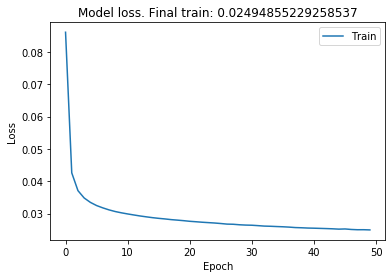

In [18]:
predicted_embed_train = encoded_subsample.model.predict(x_train_nn)
decoded_subsample = Decoder(reg=0.)
decoded_subsample.compile(loss="mean_squared_error", optimizer="adam")
decoded_subsample.train(predicted_embed_train, x_train_nn, batch_size=128, epochs=50)
decoded_subsample.plot_progress()

In [19]:
# obtain the reconstructed images
reconstruct_subsample = decoded_subsample.model.predict(predicted_embed_train)
# TODO: get final reconstruction loss

Now we can train a decoder on the original diffusion map to compare with the autoencoder. 

W0715 10:20:40.817573 4353222080 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 10:20:41.230181 4353222080 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 10:20:41.446236 4353222080 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 10:20:41.487834 4353222080 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 10:20:41.891889 4353222080 deprecation_wrapper.py:119] From /usr/local

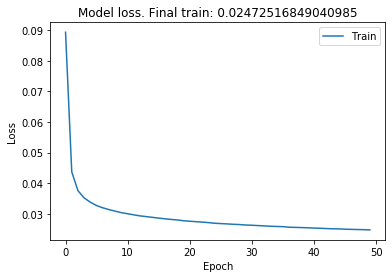

In [15]:
decoded_subsample_dm = Decoder(reg=0.)
decoded_subsample_dm.compile(loss="mean_squared_error", optimizer="adam")
decoded_subsample_dm.train(train_embed, x_train_nn, batch_size=128, epochs=50)
decoded_subsample_dm.plot_progress()

In [20]:
reconstructed_subsample_dm = decoded_subsample_dm.model.predict(train_embed)

Plot some samples to compare the orginal pictures to the reconstructed

In [137]:
def plot_reconstructed_digits(original, reconstructed, embedding_sizes = None, ncol=10, save=False):
    nrow = len(reconstructed) + 1
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(2*ncol, 2*nrow))
    data = [original] + reconstructed
    
    for i in range(nrow):
        for j in range(ncol):
            # ax = plt.subplot(nrow, ncol, i+1+j*ncol)
            axes[i, j].imshow(data[i][j].reshape((28, 28)))
            plt.gray()
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_ticks([])
    
    if embedding_sizes is not None:
        rownames = ["Original"] + [f"m = {size}" for size in embedding_sizes]
        for ax, row in zip(axes[:,0], rownames):
            ax.set_ylabel(row, rotation=90, size='large')
    
    fig.suptitle("Diffusion Net Reconstruction of MNIST", fontsize=20)
    if save:
        plt.savefig(f"./Pics/mnist_comparison{int(time.time())}.png")
    plt.show()

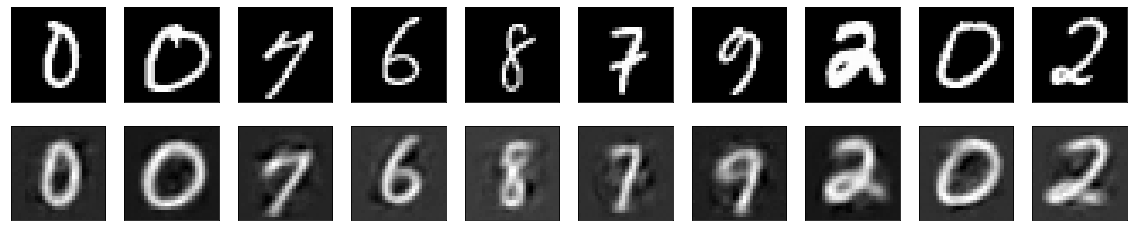

In [81]:
plot_reconstructed_digits(x_train_nn, reconstruct_subsample, save=False)

In [59]:
# Define a function to compute the reconstruction loss for comparison
def reconstruction_loss(original, reconstructed):
    return 1 / 2 *np.mean(np.linalg.norm(original - reconstructed, axis=1)**2)

In [60]:
print(f"Reconstructed loss from embedding: {reconstruction_loss(x_train_nn, reconstructed_subsample_dm)}")
print(f"Reconstructed loss from encoder: {reconstruction_loss(x_train_nn, reconstruct_subsample)}")

Reconstructed loss from embedding: 9.553235175006746
Reconstructed loss from encoder: 9.61790132645575


Comparing the decoded results from the computed embedding versus the predicted embedding, there is only a small difference. This indicated that the encoder preserves the information in the embedding. 

This result is computed with an embedding size of 32. We can do the same procedure with different embedding sizes to inspect the efficiency of the dimensionality reduction.

In [91]:
from collections import namedtuple

embedding_sizes = [4, 16, 64, 256, 784]
reconstruction_losses = []
Autoencoder = namedtuple("Autoencoder", ["encoder", "decoder"])
autoencoders = []
reconstructions = []

for emb_size in embedding_sizes:
    train_emb = embed_train_median[:, :emb_size]
    encoded = Encoder(reg=0., embedding_size=emb_size)
    encoded.compile(loss="mean_squared_error", optimizer="adam")
    encoded.train(x_train_nn, train_emb, batch_size=128, epochs=20)
    embed_pred = encoded.model.predict(x_train_nn)
    print(f"encoder_{emb_size} done")
    decoded = Decoder(reg=0.)
    decoded.compile(loss="mean_squared_error", optimizer="adam")
    decoded.train(embed_pred, x_train_nn, batch_size=128, epochs=20)
    reconstructed = decoded.model.predict(embed_pred)
    reconstructions.append(reconstructed)
    print(f"decoder_{emb_size} done")
    reconstruction_losses.append(reconstruction_loss(x_train_nn, reconstructed))
    autoencoders.append(Autoencoder(encoder=encoded, decoder=decoded))

encoder_4 done
decoder_4 done
encoder_16 done
decoder_16 done
encoder_64 done
decoder_64 done
encoder_256 done
decoder_256 done
encoder_784 done
decoder_784 done


In [148]:
# save and load
np.save("./Data/reconstructions_subsample.npy", reconstructions)

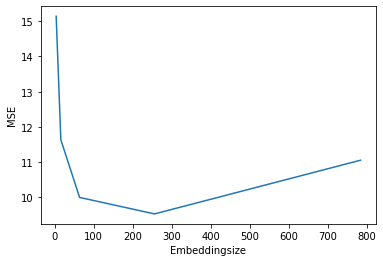

In [94]:
plt.plot(embedding_sizes, reconstruction_losses)
plt.xlabel("Embeddingsize")
plt.ylabel("MSE")
plt.show()

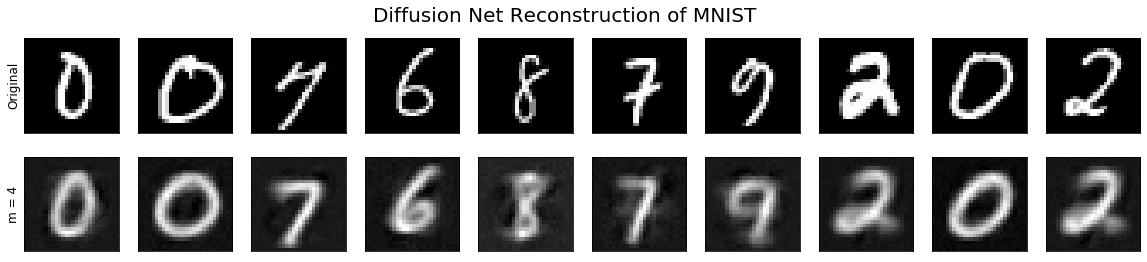

In [142]:
plot_reconstructed_digits(x_train_nn, [reconstructions[0]], embedding_sizes=[4], save=True)

The reconstruction is fairly good, but keep in mind this is only done on training data. We have to be able to extend the diffusion net for new points outside of the sample, i.e. test data. 

### Out of sample extension.
One of the main motivations for the Diffusion map is the ability to handle new samples that were not used in the embedding. So we need a model that can encode test data to the right embedding, and be able to reconstruct. 

We'll use cross-validation to test the behavior for points outside of the sample. For k-folds, the algorithm is the following:

1. Compute the embedding for the full data $X$ called $\Psi$. 
2. For each fold $X_k$ with index set $I_k = 1\{i: x_i \in  X_k\}$ do the following 
    1. Train an encoder, $\tilde{\Psi}$, on the other $k-1$ folds. 
    2. Predict the embedding for the left out $X_k$, namely $\tilde{\Psi}(X_{I_k})$
    3. Compute $\mathrm{MSE}_k = \frac{1}{|I_k|}|| \Psi (X_{I_k}) - \tilde{\Psi}(X_{I_k}) || ^2$
5. In the end compute the cross validation MSE: $\mathrm{MSE} = \frac{1}{k} \sum_i \mathrm{MSE}_i$

### Classification
Now let's train another model that goes from the embedding to a predicted class. We'll use the computed diffusion map as our training data, and use the trained model for the learned embedding for the test data. 

In [213]:
encoded_classifier_subsample = Classifier()
encoded_classifier_subsample.compile(loss="categorical_crossentropy")
encoded_classifier_subsample.train(train_embed, y_train_nn, test_embed, y_test_nn, batch_size=128, epochs=15)

Train on 10000 samples, validate on 1000 samples
Epoch 1/15
10000/10000 [==============================] - 6s 575us/step - loss: 1.1215 - acc: 0.7330 - val_loss: 1.1237 - val_acc: 0.6980
Epoch 2/15
10000/10000 [==============================] - 1s 88us/step - loss: 0.1178 - acc: 0.9689 - val_loss: 1.0576 - val_acc: 0.7160
Epoch 3/15
10000/10000 [==============================] - 1s 85us/step - loss: 0.0652 - acc: 0.9832 - val_loss: 1.0257 - val_acc: 0.7050
Epoch 4/15
10000/10000 [==============================] - 1s 104us/step - loss: 0.0573 - acc: 0.9873 - val_loss: 0.9410 - val_acc: 0.7370
Epoch 5/15
10000/10000 [==============================] - 1s 95us/step - loss: 0.0687 - acc: 0.9880 - val_loss: 0.9813 - val_acc: 0.6960
Epoch 6/15
10000/10000 [==============================] - 1s 145us/step - loss: 0.0511 - acc: 0.9915 - val_loss: 0.9356 - val_acc: 0.7200
Epoch 7/15
10000/10000 [==============================] - 1s 115us/step - loss: 0.0313 - acc: 0.9952 - val_loss: 0.9034 - val_

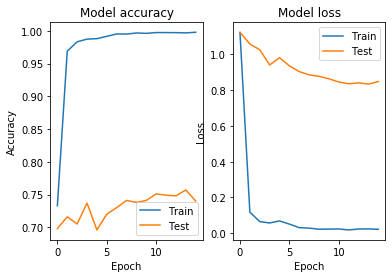

In [214]:
encoded_classifier_subsample.plot_progress()

Well, these are not great results.

Let's define a class that wraps up the whole process to make it easy to experiment and hopefully improve on this.